In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
# Get features to retain
X_train = pd.read_csv('normal_vs_disease_training_data.csv')
y_train = pd.read_csv('normal_vs_disease_training_label.csv')
y_train = np.array(y_train.drop(columns=['Unnamed: 0']))

X_test = pd.read_csv('normal_vs_disease_test_data.csv')
y_test = pd.read_csv('normal_vs_disease_test_label.csv')
y_test = np.array(y_test.drop(columns=['Unnamed: 0']))

In [ ]:
X_train.head()

,SLPI,SCGB1A1,SCGB3A1,IGLV3-19,IGHV4-34,WFDC2,BPIFB1,IGHG1,GNLY,MSMB,...,AL121748.1,AC091271.1,TMPRSS11A,GPR42,MAATS1,RNASE6,CLLU1OS,AL138781.1,KIR3DX1,BX284668.6
0,-0.250839,0.001586,-0.158335,-0.127563,-0.286497,-0.231720,-0.295893,-0.014139,-0.198845,-0.384431,...,-0.049942,0.061155,-0.049338,-0.032648,-0.053740,-0.001551,0.046797,-0.031315,-0.116844,0.011145
1,-0.185059,-0.212178,-0.297900,0.145107,0.185361,-0.150315,-0.121878,-0.004044,-0.301263,-0.145767,...,-0.021301,-0.128485,-0.049338,-0.045541,-0.105046,-0.603013,-0.060725,-0.093516,0.448147,-0.053735
2,-0.225948,-0.124393,-0.150766,-0.106845,0.062172,-0.144326,-0.135881,-0.112006,-0.284480,-0.156938,...,-0.034778,-0.134924,-0.061330,0.373200,-0.112133,-0.678061,0.027075,-0.127998,-0.095437,-0.039752
3,-0.083802,0.030607,-0.490475,0.257467,0.069671,-0.237337,-0.141693,-0.113135,-0.202260,-0.197283,...,-0.027269,-0.139735,-0.049338,-0.040633,-0.112160,-0.477225,0.101859,-0.111101,-0.069880,-0.025980
4,-0.230213,-0.081839,-0.508321,-0.314073,-0.239361,-0.241347,-0.036362,-0.142639,-0.163924,-0.121242,...,0.035969,-0.084444,-0.049093,-0.056977,-0.067658,-0.302366,-0.008489,-0.022490,-0.018191,0.181600


In [ ]:
!pip install torch_geometric

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [ ]:
# TRAINING
# Calculate the adjacency matrix (correlation matrix) for training data.
data_matrix = X_train

# correlation threshold: only variable pairs with correlation coefficients greater than 0.8 are considered highly correlated.
threshold = 0.8  

if isinstance(data_matrix, pd.DataFrame):
    data_matrix = data_matrix.to_numpy()

correlation_matrix = np.corrcoef(data_matrix)
adj_matrix = (np.abs(correlation_matrix) >= threshold).astype(int)

labels = [True if i == ['Normal'] else False for i in y_train]

# Convert adjacency matrix and node feature matrix to PyTorch Tensors
adj_matrix = torch.tensor(adj_matrix, dtype=torch.long)
feature_matrix = torch.tensor(data_matrix, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Build edge index
edge_index = adj_matrix.nonzero(as_tuple=True)
edge_index = torch.stack(edge_index, dim=0)

# Create PyTorch Geometric Data object
data_train = Data(x=feature_matrix, edge_index=edge_index, y=labels)


In [ ]:
# TESTING
# Calculate the adjacency matrix (correlation matrix) for testing data.
data_matrix = X_test 
threshold = 0.8

if isinstance(data_matrix, pd.DataFrame):
    data_matrix = data_matrix.to_numpy()

correlation_matrix = np.corrcoef(data_matrix)
adj_matrix = (np.abs(correlation_matrix) >= threshold).astype(int)

labels = [True if i == ['Normal'] else False for i in y_test]

# Convert adjacency matrix and node feature matrix to PyTorch Tensors
adj_matrix = torch.tensor(adj_matrix, dtype=torch.long)
feature_matrix = torch.tensor(data_matrix, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Build edge index
edge_index = adj_matrix.nonzero(as_tuple=True)
edge_index = torch.stack(edge_index, dim=0)

# Create PyTorch Geometric Data object
data_test = Data(x=feature_matrix, edge_index=edge_index, y=labels)


In [ ]:
class GCNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        # x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = float(pred.eq(data.y).sum().item())
        accuracy = correct / len(data.y)
        return accuracy

In [ ]:
input_dim = feature_matrix.shape[1]
hidden_dim = 64
num_classes = len(set(labels.tolist()))

model = GCNClassifier(input_dim, hidden_dim, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data_train.x, data_train.edge_index)
    #print(out.shape)
    #print(data_train.y.shape)
    loss = criterion(out, data_train.y)
    loss.backward()
    optimizer.step()
    
    # Evaluate the model on the train and test set
    train_acc = evaluate(model, data_train)
    test_acc = evaluate(model, data_test)

    print(f"Epoch: {epoch + 1}, Loss: {loss.item()}, Test Accuracy: {test_acc}")

Epoch: 1, Loss: 0.9131966233253479, Test Accuracy: 0.649818871830257
Epoch: 2, Loss: 0.8963338732719421, Test Accuracy: 0.7155425219941349
Epoch: 3, Loss: 0.6038497090339661, Test Accuracy: 0.7095049163360359
Epoch: 4, Loss: 0.5716811418533325, Test Accuracy: 0.7117474555804727
Epoch: 5, Loss: 0.5491064190864563, Test Accuracy: 0.7345178540624461
Epoch: 6, Loss: 0.5443440079689026, Test Accuracy: 0.7622908400897016
Epoch: 7, Loss: 0.5461351275444031, Test Accuracy: 0.7747110574435052
Epoch: 8, Loss: 0.5392792224884033, Test Accuracy: 0.768845954804209
Epoch: 9, Loss: 0.5248002409934998, Test Accuracy: 0.7614283249956875
Epoch: 10, Loss: 0.5102974772453308, Test Accuracy: 0.7498706227358979
Epoch: 11, Loss: 0.49807247519493103, Test Accuracy: 0.756770743488011
Epoch: 12, Loss: 0.4876028299331665, Test Accuracy: 0.775918578575125
Epoch: 13, Loss: 0.47422996163368225, Test Accuracy: 0.7914438502673797
Epoch: 14, Loss: 0.45573630928993225, Test Accuracy: 0.7995514921511127
Epoch: 15, Loss:

In [ ]:
# F1 score

model.eval()

with torch.no_grad():
    out = model(data_test.x, data_test.edge_index)
    pred = out.argmax(dim=1)
    pred = pred.tolist()
    y_test = data_test.y.tolist()
    f1 = f1_score(y_test, pred, average='weighted')
    print("f1:", f1)


f1: 0.954427300325715


In [ ]:
# Confusion matrix

cm = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cm, columns=['Predicted Positive', 'Predicted Negative'], index=['Actual Positive', 'Actual Negative'])

print(cm_df)

                 Predicted Positive  Predicted Negative
Actual Positive                2616                 171
Actual Negative                  93                2917


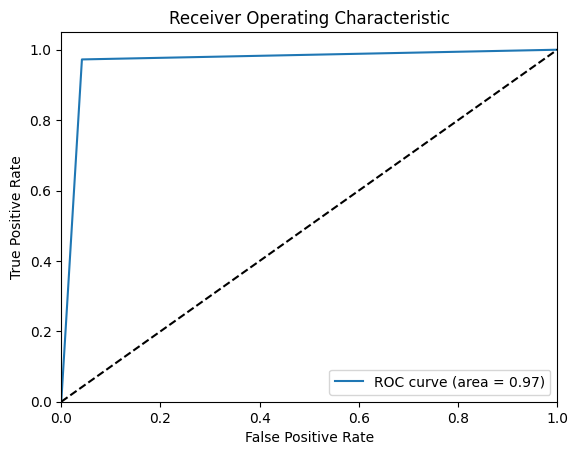

Accuracy: 0.965671899258237


In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

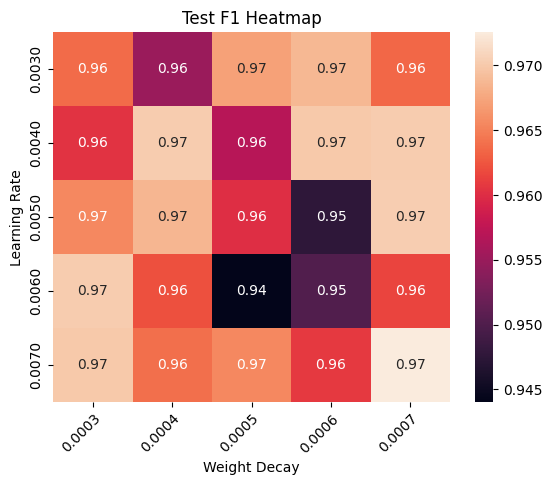

In [ ]:
# Parameter tuning result validation
x_tick_labels = [f"{wd:.4f}" for wd in weight_decays]
y_tick_labels = [f"{lr:.4f}" for lr in learning_rates]


fig, ax = plt.subplots()
sns.heatmap(results, annot=True, fmt=".2f", xticklabels=x_tick_labels, yticklabels=y_tick_labels, ax=ax)


ax.set_xlabel("Weight Decay")
ax.set_ylabel("Learning Rate")
ax.set_title("Test F1 Heatmap")

ax.set_xticks(np.arange(len(weight_decays)) + 0.5)
ax.set_yticks(np.arange(len(learning_rates)) + 0.5)


ax.set_xticklabels(x_tick_labels)
ax.set_yticklabels(y_tick_labels)


plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')


plt.show()

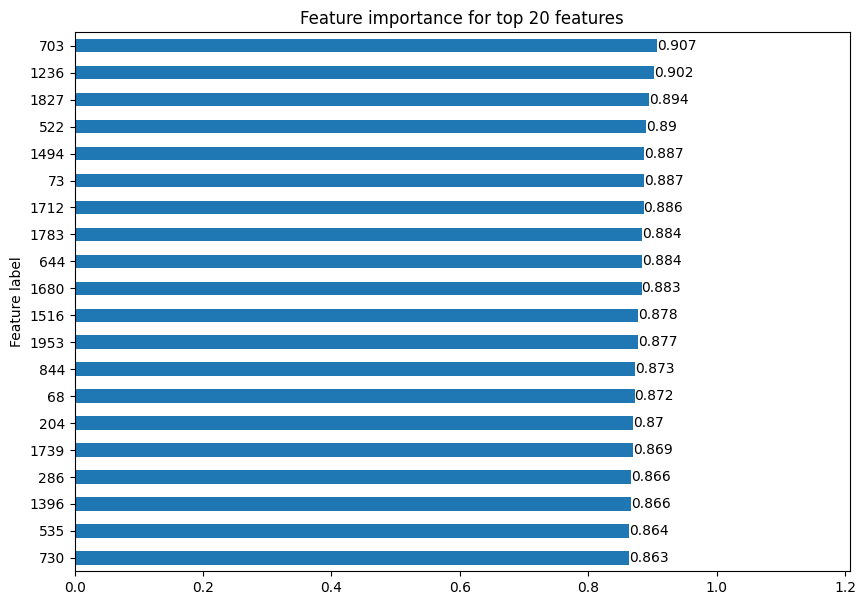

In [ ]:
# Explainable AI

from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import to_networkx
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',
    ),
)

node_index = 0 #which node (cell) to intepretate
explanation = explainer(data_test.x, data_test.edge_index, index=node_index)
explanation.visualize_feature_importance(top_k=20)